# tf.keras Kullanarak Görüntü Sınıflandırma

Bu colab dosyasında çiçek resimlerini sınıflandıracağız. `tf.keras.Sequential` modelini kullanarak bir görüntü sınıflandırıcı oluşturacağız ve gerekli olan verileri `tf.keras.preprocessing.image.ImageDataGenerator` kullanarak yükleyeceğiz.

## Gerekli Paketlerin İçeri Aktarılması

Gerekli paketleri içeri aktararak başlayalım. `os` paketi, dosyaları ve dizin yapısı için kullanılır. `numpy` paketi, Python listelerini numpt dizisine dönüştürmek ve gerekli matris işlemlerini gerçekleştirmek için kullanılır. `matplotlib.pyplot` paketi, grafikleri çizmek ve eğitimi-doğrulama verilerimizi görüntülemek için kullanılır.

In [1]:
import os
import numpy as np
import glob
import shutil
import matplotlib.pyplot as plt

### TensorFlow ve Keras Katmanlarının İçeri Aktarılması

Aşağıdaki hücrede, CNN oluşturmak için kullanacağımız TensorFlow ve Keras katmanlarını, modellerini içeri aktarıyoruz. Ayrınca veri seti büyütme işlemlerini gerçekleştirmek için `ImageDataGenerator` sınıfını Keras'tan içeri aktarıyoruz.

In [2]:
import tensorflow as tf

In [3]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## Verilerin Yüklenmesi

Görüntü sınıflandırıcımızı oluşturmak için çiçekler veri setini indirmeliyiz. Öncelikle veri setinin arşiv versiyonunu indirmemiz gerekiyor. İndirme işleminden sonra bu arşiv dosyasını `/tmp/` dizinine kaydediyoruz.

In [4]:
_URL = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"

zip_file = tf.keras.utils.get_file(origin=_URL,
                                   fname="flower_photos.tgz",
                                   extract=True)

base_dir = os.path.join(os.path.dirname(zip_file), 'flower_photos')

228818944/228813984 [==============================] - 1s 0us/step


İndirdiğimiz veri seti 5 farklı çiçek türünden oluşan görseller içeriyor:

1. Gül (roses)
2. Papatya (daisy)
3. Karahindiba (dandelion)
4. Ayçiçeği (sunflowers)
5. Lale (tulips)

Şimdi bu 5 sınıf için etiketler oluşturalım:

In [5]:
classes = ['roses', 'daisy', 'dandelion', 'sunflowers', 'tulips']

Ayrıca indirdiğimiz veri seti aşağıdaki dizin yapısına sahiptir:

<pre style="font-size: 10.0pt; font-family: Arial; line-height: 2; letter-spacing: 1.0pt;" >
<b>flower_photos</b>
|__ <b>daisy</b>
|__ <b>dandelion</b>
|__ <b>roses</b>
|__ <b>sunflowers</b>
|__ <b>tulips</b>
</pre>

Gördüğünüz gibi eğitim ve doğrulama verilerini içeren bir klasör yok. Bu nedenle kendi eğitim ve doğrulama setimizi oluşturmamız gerekecek. Bunu yapacak kodu yazmamız gerekiyor.

Aşağıdaki kod, her biri 5 klasör (her çiçek türü için bir tane) içeren bir eğitim (`train`) ve bir doğrulama (`val`) klasörü oluşturur. Daha sonra görüntülerin %80'i eğitim setine ve geriye kalan %20'si doğrulama setine gidecek şekilde görüntüleri orijinal klasörlerinden bu yeni oluşturulan klasörlere taşır. Sonunda dizinimiz aşağıdaki yapıya sahip olacaktır:

<pre style="font-size: 10.0pt; font-family: Arial; line-height: 2; letter-spacing: 1.0pt;" >
<b>flower_photos</b>
|__ <b>daisy</b>
|__ <b>dandelion</b>
|__ <b>roses</b>
|__ <b>sunflowers</b>
|__ <b>tulips</b>
|__ <b>train</b>
    |______ <b>daisy</b>: [1.jpg, 2.jpg, 3.jpg ....]
    |______ <b>dandelion</b>: [1.jpg, 2.jpg, 3.jpg ....]
    |______ <b>roses</b>: [1.jpg, 2.jpg, 3.jpg ....]
    |______ <b>sunflowers</b>: [1.jpg, 2.jpg, 3.jpg ....]
    |______ <b>tulips</b>: [1.jpg, 2.jpg, 3.jpg ....]
 |__ <b>val</b>
    |______ <b>daisy</b>: [507.jpg, 508.jpg, 509.jpg ....]
    |______ <b>dandelion</b>: [719.jpg, 720.jpg, 721.jpg ....]
    |______ <b>roses</b>: [514.jpg, 515.jpg, 516.jpg ....]
    |______ <b>sunflowers</b>: [560.jpg, 561.jpg, 562.jpg .....]
    |______ <b>tulips</b>: [640.jpg, 641.jpg, 642.jpg ....]
</pre>

Orijinal klasörleri silmediğimiz için hala `flower_photos` dizinimizde olacaklar ama içleri boş olacaktır. Aşağıdaki kod, her bir çiçek türü için sahip olduğumuz toplam çiçek resmi sayısını yazdırır:


In [6]:
for cl in classes:
  img_path = os.path.join(base_dir, cl)
  images = glob.glob(img_path + '/*.jpg')
  print("{}: {} Görüntü".format(cl, len(images)))
  num_train = int(round(len(images)*0.8))
  train, val = images[:num_train], images[num_train:]

  for t in train:
    if not os.path.exists(os.path.join(base_dir, 'train', cl)):
      os.makedirs(os.path.join(base_dir, 'train', cl))
    shutil.move(t, os.path.join(base_dir, 'train', cl))

  for v in val:
    if not os.path.exists(os.path.join(base_dir, 'val', cl)):
      os.makedirs(os.path.join(base_dir, 'val', cl))
    shutil.move(v, os.path.join(base_dir, 'val', cl))

roses: 641 Görüntü
daisy: 633 Görüntü
dandelion: 898 Görüntü
sunflowers: 699 Görüntü
tulips: 799 Görüntü


In [7]:
round(len(images)*0.8)

639

Kolaylk olması için eğitim ve doğrulama veri kümelerinin yollarını (PATH) oluşturalım.

In [8]:
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')

## Veri Seti Büyütme 

Aşırı uyum (overfitting) genellikle az sayıda eğitim örneğimiz olduğunda ortaya çıkar. Bu sorunu çözmenin bir yolu, veri setimizi yeterli sayıda ve çeşitli eğitim örneklerine sahip olacak şekilde genişletmektir. Veri büyütme (Data Augmentation) rasgele dönüşümler yoluyla örnekleri çoğaltarak, mevcut eğitim örneklerinden daha fazla eğitim verisi üretme yaklaşımını benimser. Amaç, eğitim sırasında modelimizin aynı resmi asla iki kez görmemesidir. Bu, modeli verilerin daha fazla yönüne maruz bırakarak daha iyi genelleştirmesine olanak tanır.

`tf.keras` sınıfında bunu daha önce kullandığımız `ImageDataGenerator` sınıfını kullanarak uygulayabiliriz. İstediğimiz farklı dönüşümleri bir argüman biçimi olarak veri kümemize geçirebiliriz.

Başlamak için, gerçekleştirilen bütütmenin türünü görebilmek için bir görüntüyü görüntüleyen bir işlev tanımlayalım. Ardından, eğitim sırasında kullanacağımız belirli argümanlara bakalım.

In [10]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

### Parti (Batch) ve Görüntü Boyutunun (Image Size) Ayarlanması

Aşağıdaki hücrede ilerleyen zamanda kullanacağımız iki parametre kolaylık olması için tanımlanmıştır. 1oo resimden oluşan bir parti (grup) boyumuz ve eğitim verilerimiz 150 x 150 boyutunda oluğu için `IMG_SHAPE` değişkenimiz de bu değere atanmıştır.

In [11]:
batch_size = 100
IMG_SHAPE = 150 

### Rastgele Yatay Çevirme

Aşağıdaki hücredei görüntüleri 255'e bölerek yeniden ölçeklendiren ve ardından rastgele yatay bir çevirme uygulayan bir dönüşüm oluşturuyoruz. Bu işlevi yaparkan `ImageDataGenerator` kullanıyoruz.

In [12]:
image_gen = ImageDataGenerator(rescale=1./255, horizontal_flip=True)

train_data_gen = image_gen.flow_from_directory(
                                                batch_size=batch_size,
                                                directory=train_dir,
                                                shuffle=True,
                                                target_size=(IMG_SHAPE,IMG_SHAPE)
                                                )

Found 2935 images belonging to 5 classes.


Eğitim örneklerimiden 1 örnek alıp 5 kez tekrarlayalım ki veri büyütme aynı görüntüye beş kez uygulanabilsin.

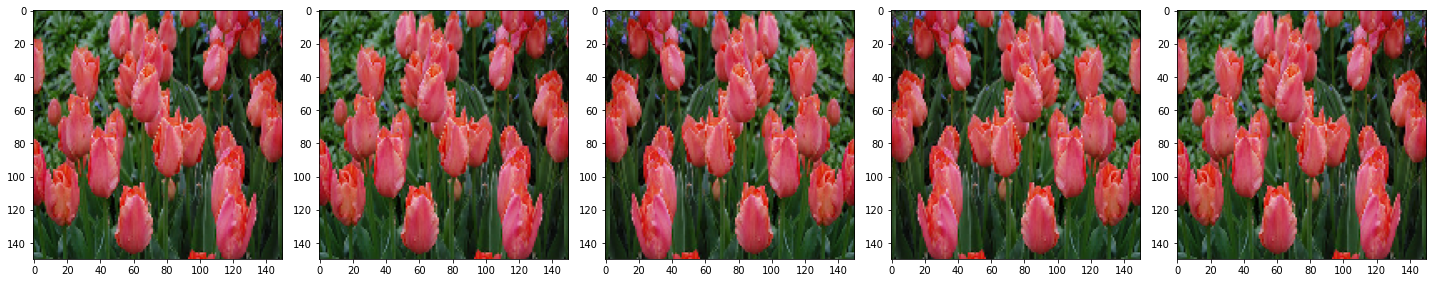

In [14]:
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

### Rastgele Döndürme

Aşağıdaki hücredei görüntüleri 255'e bölerek yeniden ölçeklendiren ve ardından rastgele 45 derece döndürme uygulayan bir dönüşüm oluşturuyoruz. Bu işlevi yaparkan `ImageDataGenerator` kullanıyoruz. Ardından dönüşümü eğitim setimize uygulamak için `.flow_from_directory` yöntemini kullanıyoruz.

In [15]:
image_gen = ImageDataGenerator(rescale=1./255, rotation_range=45)

train_data_gen = image_gen.flow_from_directory(batch_size=batch_size,
                                               directory=train_dir,
                                               shuffle=True,
                                               target_size=(IMG_SHAPE, IMG_SHAPE))

Found 2935 images belonging to 5 classes.


Eğitim örneklerimiden 1 örnek alıp 5 kez tekrarlayalım ki veri büyütme aynı görüntüye beş kez uygulanabilsin.

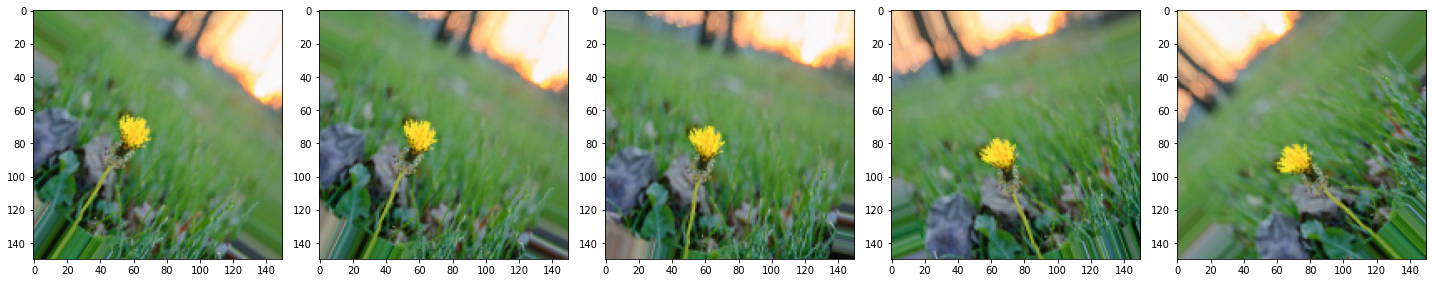

In [16]:
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

### Rastgele Yakınlaştırma

Aşağıdaki hücredei görüntüleri 255'e bölerek yeniden ölçeklendiren ve ardından rastgele %50'te kadar yakınlaştırma uygulayan bir dönüşüm oluşturuyoruz. Bu işlevi yaparkan `ImageDataGenerator` kullanıyoruz. Ardından dönüşümü eğitim setimize uygulamak için `.flow_from_directory` yöntemini kullanıyoruz.

In [17]:
image_gen = ImageDataGenerator(rescale=1./255, zoom_range=0.5)

train_data_gen = image_gen.flow_from_directory(
                                                batch_size=batch_size,
                                                directory=train_dir,
                                                shuffle=True,
                                                target_size=(IMG_SHAPE, IMG_SHAPE)
                                                )

Found 2935 images belonging to 5 classes.


Eğitim örneklerimiden 1 örnek alıp 5 kez tekrarlayalım ki veri büyütme aynı görüntüye beş kez uygulanabilsin.

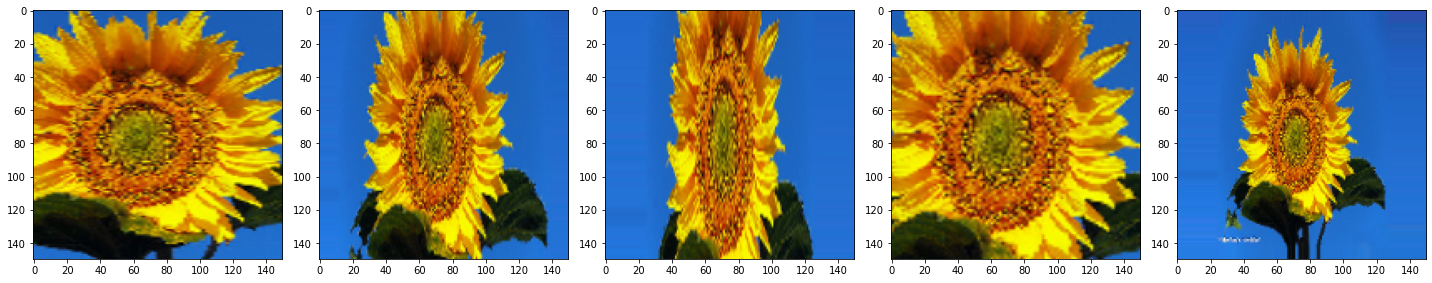

In [18]:
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

### Hepsini Bir Araya Getirelim

Aşağıdaki kod hücresinde, görüntüleri 255'e kadar yeniden ölçeklendirir ve geçerli olan bir dönüşüm uygulaması oluşturmak için `ImageDataGenerator` sınıfını kullanır.

- Rastgele 45 derece döndürme
- Rastgele %50 yakınlaştırma
- Rastgele yatay çevirme
- Yatay 0.15 kayma
- Dikey 0.15 kayma

Bu işlemlerden sonra bu dönüşümleri eğitim setimizdeki görüntülere uygulamak için `.flow_from_directory` yöntemini kullanıyoruz.

In [19]:
image_gen_train = ImageDataGenerator(
                    rescale=1./255,
                    rotation_range=45,
                    width_shift_range=.15,
                    height_shift_range=.15,
                    horizontal_flip=True,
                    zoom_range=0.5
                    )


train_data_gen = image_gen_train.flow_from_directory(
                                                batch_size=batch_size,
                                                directory=train_dir,
                                                shuffle=True,
                                                target_size=(IMG_SHAPE,IMG_SHAPE),
                                                class_mode='sparse'
                                                )

Found 2935 images belonging to 5 classes.


Bu veri büyütmeyi veri setimize aktardığımıza göre 5 farklı kez nasıl görüneceğini görselleştirelim.

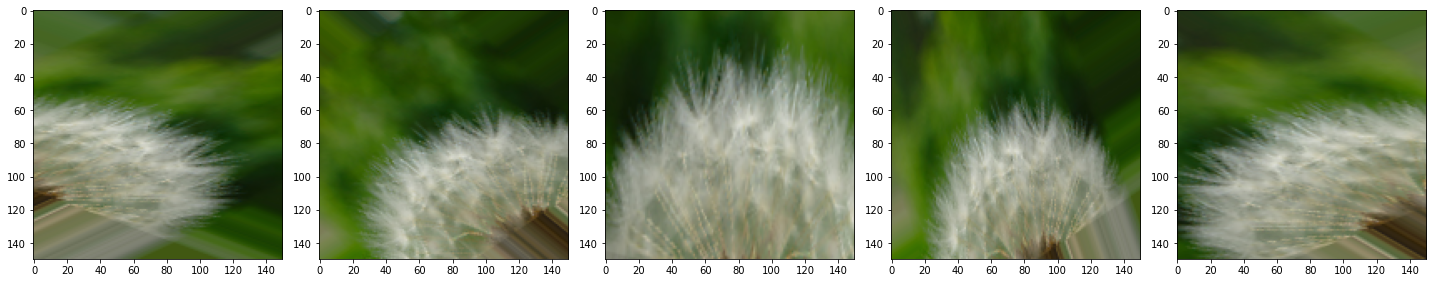

In [20]:
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

## Doğrulama Kümesi için Veri Seti Oluşturucunun Tanımlanması

Genel olarak, orijinal görüntülerin modelimizin yönetmesi gerekenleri temsil etmesi gerektiği için, yalnızca eğitim örneklerimize veri büyütme uygularız. Bu durumda, yalnızca doğrulama görüntülerimizi yeniden ölçeklendiriyoruz.

In [21]:
image_gen_val = ImageDataGenerator(rescale=1./255)

val_data_gen = image_gen_val.flow_from_directory(batch_size=batch_size,
                                                 directory=val_dir,
                                                 target_size=(IMG_SHAPE, IMG_SHAPE),
                                                 class_mode='sparse')

Found 735 images belonging to 5 classes.


## CNN'in Oluşturulması

Aşağıdaki hücrede, 3 evrişim katmanından oluşan bir evrişimsel sinir ağı oluşturuyoruz. Her evrişimsel blok, bir `Conv2D` ve ardından bir maksimum havuz katmanı içermektedir. İlk evrişim bloğu 16 filreye, ikincisi 32 fitreye ve üçüncüsü ise 64 filtreye sahiptir. Tüm evrişimsel filtreler 3x3 boyutundadır. Tüm maksimum havuz katmanlarının `pool_size` (havuz boyu) değişkeni `(2,2)` dir. 

3 evrişim bloğundan sonrai düzeleştirilmiş (*Flatten*) bir katmana ve ardından 512 birimli tam bağlantılı bir katmana sahiptir. CNN, `softmax` aktivasyon fonksiyonu tarafından yapılan 5 sınıfa dayalı sınıf olasılıkları verir. Diğer tüm katmanlar bir yeniden etkinleştirme işlevi (`relu`) kullanır. Ayrıca %20 olasılıkla bırakma yapacak bir bırakma (*dropout*) katmanı sayesinde aşırı uyumdan kaçınmış oluruz.

In [22]:
model = Sequential()

model.add(Conv2D(16, 3, padding='same', activation='relu', input_shape=(IMG_SHAPE,IMG_SHAPE, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, 3, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, 3, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dropout(0.2))
model.add(Dense(512, activation='relu'))

model.add(Dropout(0.2))
model.add(Dense(5))

## Modelin Derlenmesi

Aşağıdaki kod bloğunda modelimiz için adam optimize edici kullanıyoruz. Bir softmax kategorizasyonu ürettiğimizde, kayıp fonksiyonu olarak (loss func) sparse_categorical_crossentropy kullanacağız. Ayrıca ağımızı eğitirken her bir yineleme de (epoch) eğitim ve doğrulama durumuna bakmak istiyoruz, bu nedenle metrik argümanını accuracy (doğruluk) olarak seçiyoruz.

In [23]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

Modelin Eğitilmesi

Aşağıda kod bloğunda, modelinizi normal `fit` işlevi yerine `fit_generator` kullanarak eğitiyoruz. Modelimizin eğitim ve doğrulama verilerini oluşturmak için `ImageDataGenerator` kullandığımız için `fit_generator` kullanmak zorunda kalırız. Modeli 80 dönem (*epoch*) için eğitiyoruz.

In [24]:
epochs = 80

history = model.fit_generator(
    train_data_gen,
    steps_per_epoch=int(np.ceil(train_data_gen.n / float(batch_size))),
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=int(np.ceil(val_data_gen.n / float(batch_size)))
)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/80
30/30 [==============================] - 55s 764ms/step - loss: 1.6598 - accuracy: 0.2920 - val_loss: 1.3272 - val_accuracy: 0.4558
Epoch 2/80
30/30 [==============================] - 24s 810ms/step - loss: 1.2467 - accuracy: 0.4675 - val_loss: 1.1363 - val_accuracy: 0.4952
Epoch 3/80
30/30 [==============================] - 23s 774ms/step - loss: 1.1251 - accuracy: 0.5383 - val_loss: 1.0893 - val_accuracy: 0.5605
Epoch 4/80
30/30 [==============================] - 23s 791ms/step - loss: 1.0603 - accuracy: 0.5768 - val_loss: 0.9685 - val_accuracy: 0.6354
Epoch 5/80
30/30 [==============================] - 24s 810ms/step - loss: 1.0100 - accuracy: 0.6082 - val_loss: 0.9644 - val_accuracy: 0.6354
Epoch 6/80
30/30 [==============================] - 23s 774ms/step - loss: 0.9507 - accuracy: 0.6310 - val_loss: 0.8998 - val_accuracy: 0.6585
Epoch 7/80
30/30 [==============================] - 24s 803ms/step - loss: 0.9157 - accuracy: 0.6368 - val_loss: 0.8728 - val_accuracy: 0.6803

## Eğitim ve Doğrulama Verilerinin Görselleştirilmesi

Aşağıdaki hücredei eğitim ve doğrulama verilerimiz için doğruluk/kayıp grafiklerini çiziyoruz.

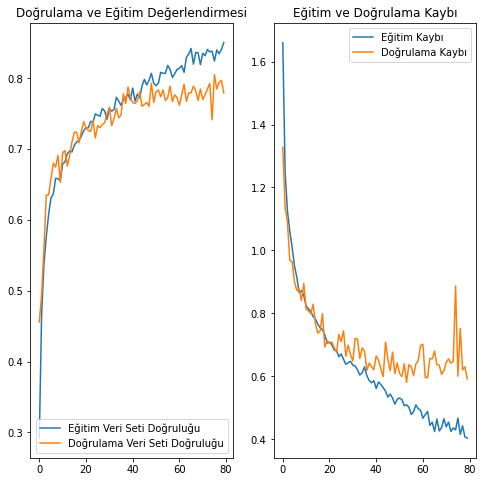

In [25]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Eğitim Veri Seti Doğruluğu')
plt.plot(epochs_range, val_acc, label='Doğrulama Veri Seti Doğruluğu')
plt.legend(loc='lower right')
plt.title('Doğrulama ve Eğitim Değerlendirmesi')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Eğitim Kaybı')
plt.plot(epochs_range, val_loss, label='Doğrulama Kaybı')
plt.legend(loc='upper right')
plt.title('Eğitim ve Doğrulama Kaybı')
plt.show()